In [59]:
import importlib
import os
import sys

import amici
import libsbml
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import pypesto

# sbml file
sbml_file = "conversion_reaction.xml"

# name of the model that will also be the name of the python module
model_name = "conversion_reaction"

# output directory
model_output_dir = "tmp/" + model_name

## The example model

Here we use `libsbml` to show the reactions and species described by the model (this is independent of AMICI). The notebook creates Figure 1 B for the paper.

In [2]:
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(os.path.abspath(sbml_file))
sbml_model = sbml_doc.getModel()
dir(sbml_doc)
print(os.path.abspath(sbml_file))
print("Species: ", [s.getId() for s in sbml_model.getListOfSpecies()])
print("Parameters: ", [p.getId() for p in sbml_model.getListOfParameters()])

print("\nReactions:")
for reaction in sbml_model.getListOfReactions():
    reactants = " + ".join(
        [
            "%s %s"
            % (
                int(r.getStoichiometry()) if r.getStoichiometry() > 1 else "",
                r.getSpecies(),
            )
            for r in reaction.getListOfReactants()
        ]
    )
    products = " + ".join(
        [
            "%s %s"
            % (
                int(r.getStoichiometry()) if r.getStoichiometry() > 1 else "",
                r.getSpecies(),
            )
            for r in reaction.getListOfProducts()
        ]
    )
    reversible = "<" if reaction.getReversible() else ""
    print(
        "%3s: %10s %1s->%10s\t\t[%s]"
        % (
            reaction.getId(),
            reactants,
            reversible,
            products,
            libsbml.formulaToL3String(reaction.getKineticLaw().getMath()),
        )
    )

/Users/pauljonasjost/Documents/GitHub_Folders/Lipidomics/Toy_models/conversion_reaction.xml
Species:  ['A', 'B']
Parameters:  ['k1', 'k2', 'k3', 'k4']

Reactions:
A_syn:             ->         A		[compartment * Constant_flux__irreversible(k1)]
A_to_B:          A  ->         B		[compartment * k2 * A]
B_to_A:          B  ->         A		[compartment * k3 * B]
B_deg:          B  ->          		[compartment * k4 * B]


## Importing an SBML model, compiling and generating an AMICI module

Before we can use AMICI to simulate our model, the SBML model needs to be translated to C++ code. This is done by `amici.SbmlImporter`.

In [3]:
# Create an SbmlImporter instance for our SBML model
sbml_importer = amici.SbmlImporter(sbml_file)

### Generating the module

Now we can generate the python module for our model. `amici.SbmlImporter.sbml2amici` will symbolically derive the sensitivity equations, generate C++ code for model simulation, and assemble the python module.

In [4]:
sbml_importer.sbml2amici(
    model_name,
    model_output_dir
)

### Importing the module and loading the model

If everything went well, we need to add the previously selected model output directory to our PYTHON_PATH. After this we are ready to load the newly generated model:

In [5]:
sys.path.insert(0, os.path.abspath(model_output_dir))
model_module = importlib.import_module(model_name)

Afterwards, we can get an instance of our model from which we can retrieve information such as parameter names:

In [6]:
model = model_module.getModel()

print("Model parameters:", list(model.getParameterIds()))
print("Model outputs:   ", list(model.getObservableIds()))
print("Model states:    ", list(model.getStateIds()))

Model parameters: ['k1', 'k2', 'k3', 'k4']
Model outputs:    ['yA', 'yB', 'ycompartment']
Model states:     ['A', 'B']


## Running simulations and analyzing results

After importing the model, we can run simulations using `amici.runAmiciSimulation`. This requires a `Model` instance and a `Solver` instance. Optionally you can provide measurements inside an `ExpData` instance, as shown later in this notebook.

In [78]:
# set timepoints
# model.setTimepoints(np.linspace(0, 40, 41))
timepoints_fig1a = np.logspace(-1, 1, 41, base=40)
model.setTimepoints(timepoints_fig1a)

# set starting points
start_mean = np.array([2.0, 2.0])
# add normally distributed noise with standard deviation 0.1
start1 = start_mean + np.random.normal(0, 0.1, 2)
start2 = start_mean + np.random.normal(0, 0.1, 2)
start3 = start_mean + np.random.normal(0, 0.1, 2)
start4 = start_mean + np.random.normal(0, 0.1, 2)

# Create solver instance
solver = model.getSolver()

# create three sets of parameters, all parameters are set to 1.0 plus normally distributed noise with standard deviation 0.1
parameters_1 = np.array([1.0] * model.np()) + np.random.normal(0, 0.1, model.np())
parameters_2 = np.array([1.0] * model.np()) + np.random.normal(0, 0.1, model.np())
parameters_3 = np.array([1.0] * model.np()) + np.random.normal(0, 0.1, model.np())
parameters_4 = np.array([1.0] * model.np()) + np.random.normal(0, 0.1, model.np())

# run simulation for each set of parameters
model.setParameters(parameters_1)
model.setInitialStates(start1)
rdata_1 = amici.runAmiciSimulation(model, solver)
model.setParameters(parameters_2)
model.setInitialStates(start2)
rdata_2 = amici.runAmiciSimulation(model, solver)
model.setParameters(parameters_3)
model.setInitialStates(start3)
rdata_3 = amici.runAmiciSimulation(model, solver)
model.setParameters(parameters_4)
model.setInitialStates(start4)
rdata_4 = amici.runAmiciSimulation(model, solver)

In [79]:
meas_1 = rdata_1.x
meas_2 = rdata_2.x
meas_3 = rdata_3.x
meas_4 = rdata_4.x
meas = [meas_1, meas_2, meas_3, meas_4]

In [80]:
# colors for cells
plt.rcParams['axes.edgecolor']='black'
colors_c = ["#007f5f", "#aacc00", "#942193", "#17c3b2"]

# Picture for timepoint clouds

In [81]:
# create 100 sets of parameters, all parameters are set to 1.0 plus normally distributed noise with standard deviation 0.1. Also check that a values are positive
n_samples = 1000
parameters = np.array([1.0] * model.np()) + np.random.normal(0, 0.1, (n_samples, model.np()))
startpoints = np.array([2.0, 2.0]) + np.random.normal(0, 0.1, (n_samples, 2))
if np.any(parameters < 0):
    raise ValueError("Negative parameter values encountered")

In [82]:
# run simulation for all parameters and save each timepoint result in a different array
t_10 = np.zeros((n_samples, 2))
t_0 = np.zeros((n_samples, 2))
t_20 = np.zeros((n_samples, 2))
t_40 = np.zeros((n_samples, 2))
for i, p in enumerate(parameters):
    model.setParameters(p)
    model.setInitialStates(startpoints[i, :])
    rdata = amici.runAmiciSimulation(model, solver)
    t_10[i, :] = rdata.x[10, :]
    t_0[i, :] = rdata.x[0, :]
    t_20[i, :] = rdata.x[20, :]
    t_40[i, :] = rdata.x[40, :]

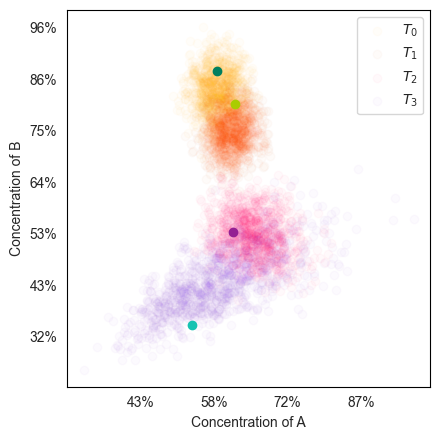

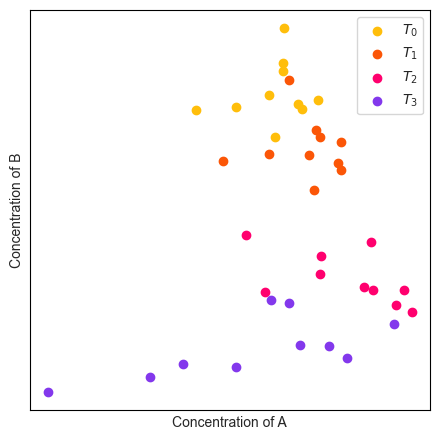

In [83]:
# colors for timepoints:
colors_t = ["#ffbe0b", "#fb5607", "#ff006e", "#8338ec"]

# draw a plot x-axis being species 1, y-axis being species 2
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
# draw the points in the timepoint clouds and them transparent
ax.scatter(t_0[:, 0], t_0[:, 1], color=colors_t[0], alpha=0.025, label="$T_0$")
ax.scatter(t_10[:, 0], t_10[:, 1], color=colors_t[1], alpha=0.025, label="$T_1$")
ax.scatter(t_20[:, 0], t_20[:, 1], color=colors_t[2], alpha=0.025, label="$T_2$")
ax.scatter(t_40[:, 0], t_40[:, 1], color=colors_t[3], alpha=0.025, label="$T_3$")

# add legend on the upper right but make the points in the legend
ax.legend(loc="upper right")

# add one point for each cell
ax.scatter(meas_1[0, 0], meas_1[0, 1], color=colors_c[0], alpha=1, label="cell 1")
ax.scatter(meas_2[10, 0], meas_2[10, 1], color=colors_c[1], alpha=1, label="cell 2")
ax.scatter(meas_3[20, 0], meas_3[20, 1], color=colors_c[2], alpha=1, label="cell 3")
ax.scatter(meas_4[40, 0], meas_4[40, 1], color=colors_c[3], alpha=1, label="cell 4")

# add labels
ax.set_xlabel("Concentration of A")
ax.set_ylabel("Concentration of B")

# # remove ticks and labels
# ax.set_xticks([])
# ax.set_yticks([])
# get limits
x = ax.get_xlim()
y = ax.get_ylim()
ax.grid(False)
# relative measurements
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = y[1]))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = x[1]))

fig.tight_layout()

plt.savefig("conversion_reaction_timepoint_clouds.pdf")

# plot the same plot but non transparent
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
# draw the points in the timepoint clouds and them transparent
ax.scatter(t_0[0:10, 0], t_0[0:10, 1], color=colors_t[0], alpha=1, label="$T_0$")
ax.scatter(t_10[0:10, 0], t_10[0:10, 1], color=colors_t[1], alpha=1, label="$T_1$")
ax.scatter(t_20[0:10, 0], t_20[0:10, 1], color=colors_t[2], alpha=1, label="$T_2$")
ax.scatter(t_40[0:10, 0], t_40[0:10, 1], color=colors_t[3], alpha=1, label="$T_3$")

# add legend on the upper right out of the plot
ax.legend(loc="upper right")
# add labels
ax.set_xlabel("Concentration of A")
ax.set_ylabel("Concentration of B")
ax.grid(False)
# remove ticks and labels
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

plt.savefig("conversion_reaction_timepoint_clouds_non_transparent.pdf")

In [84]:
# take out 3 random parameters from parameters
p_rand = parameters[np.random.choice(n_samples, 3, replace=False), :]

# run simulation for all parameters and save the results
data_rand = []
for p in p_rand:
    model.setParameters(p)
    # take out the 0th, 10th, 20th and 40th timepoint
    data_rand.append(amici.runAmiciSimulation(model, solver).x[[0, 10, 20, 40], :])

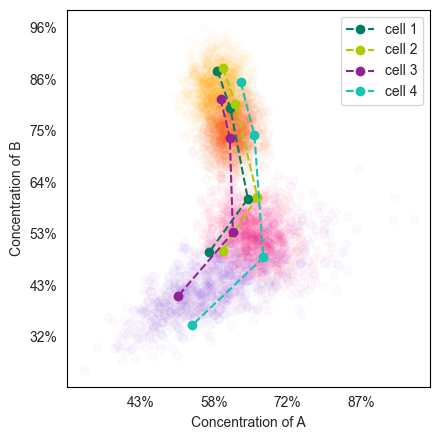

In [85]:
# draw a plot x-axis being species 1, y-axis being species 2
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

# draw the clouds
ax.scatter(t_0[:, 0], t_0[:, 1], color=colors_t[0], alpha=0.025)
ax.scatter(t_10[:, 0], t_10[:, 1], color=colors_t[1], alpha=0.025)
ax.scatter(t_20[:, 0], t_20[:, 1], color=colors_t[2], alpha=0.025)
ax.scatter(t_40[:, 0], t_40[:, 1], color=colors_t[3], alpha=0.025)

for i, measure in enumerate(meas):
    d = measure[[0, 10, 20, 40], :]
    ax.plot(d[:, 0], d[:, 1], label=f"cell {i + 1}", linestyle="--", marker="o", color = colors_c[i])

# add legend
ax.legend()
# add labels
ax.set_xlabel("Concentration of A")
ax.set_ylabel("Concentration of B")

# # remove ticks and labels
# ax.set_xticks([])
# ax.set_yticks([])

# relative measurements
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = y[1]))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = x[1]))
ax.grid(False)
fig.tight_layout()

plt.savefig("conversion_reaction_timepoint_clouds_with_trajectories.pdf")

In [86]:
x = ax.get_xlim()
y = ax.get_ylim()
print(x,y)

(1.000406878373493, 3.467501280673233) (0.5082861146682656, 2.3365652093393323)


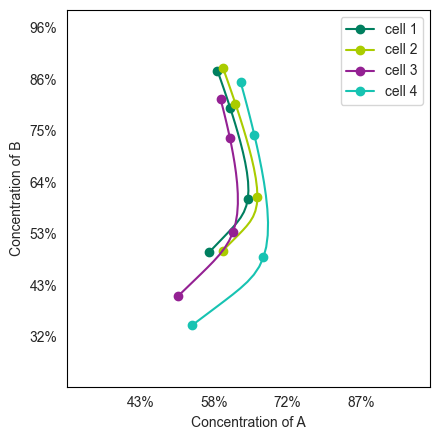

In [87]:
# draw a plot x-axis being species 1, y-axis being species 2
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
ax.plot(meas_1[:, 0], meas_1[:, 1], label="cell 1", color = "#007f5f", linestyle="-", markevery = [0, 10, 20, 40], marker = 'o')
ax.plot(meas_2[:, 0], meas_2[:, 1], label="cell 2", color="#aacc00", linestyle="-", markevery = [0, 10, 20, 40], marker = 'o')
ax.plot(meas_3[:, 0], meas_3[:, 1], label="cell 3", color="#942193" , linestyle="-", markevery = [0, 10, 20, 40], marker = 'o')
ax.plot(meas_4[:, 0], meas_4[:, 1], label="cell 4", color="#17c3b2", linestyle="-", markevery = [0, 10, 20, 40], marker = 'o')
# add legend
ax.legend()
# add labels
ax.set_xlabel("Concentration of A")
ax.set_ylabel("Concentration of B")

# # remove ticks and labels
# ax.set_xticks([])
# ax.set_yticks([])

ax.set_xlim(x)
ax.set_ylim(y)

# relative measurements
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = y[1]))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = x[1]))

ax.grid(False)

fig.tight_layout()

fig.savefig("conversion_reaction.pdf")